In [2]:
import torch 
from torch import nn
import torch.nn.functional as F 
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
# import util
from datetime import date
import argparse
from progressbar import *
import datetime

## Config

In [28]:
# config 

num_epochs = 100
step_per_epoch = 3
n_layers = 1
likelihood = 'g'
num_obs_to_train = 50
embedding_size = 10
hidden_size = 50
seq_len = 28
batch_size=64
lr = 1e-3

## Load Data

In [5]:
from torch.utils.data import Dataset
import torch
from torch.utils import data
from torch.utils.data import DataLoader
class WindowDataset(Dataset):
    '''
    Build a custom dataset 
    
    --Return--
    
    x: inputs
    y: targets 
    z: features
    ----------
    
    '''
    
    def __init__(self, data, input_window, output_window, stride=1):
        # total data length 
        L = data.shape[0]
        
        # total number of samples with stride
        num_samples = (L - input_window - output_window) // stride + 1
        
        # input, output 
        X = []
        Y = []
        Xf = []
        Yf = []
        
        for i in range(num_samples):
            start_x = stride*i
            end_x = start_x + input_window 
            Y.append(data.iloc[start_x: end_x, 0].values)
            X.append(data.iloc[start_x: end_x, 1:].values)
            start_y = stride*i + input_window
            end_y = start_y + output_window 
            Yf.append(data.iloc[start_y:end_y, 0].values)
            Xf.append(data.iloc[start_y:end_y, 1:].values)
            
        self.X = X
        self.Y = Y
        self.Xf = Xf
        self.Yf = Yf
        
        self.len = len(X)
            
    def __len__(self):
        return self.len 
    
    def __getitem__(self, idx):
        X = torch.FloatTensor(self.X[idx])
        Y = torch.FloatTensor(self.Y[idx])
        Y = Y.unsqueeze(-1)
        Xf = torch.FloatTensor(self.Xf[idx])
        Yf = torch.FloatTensor(self.Yf[idx])
        Yf = Yf.unsqueeze(-1)
        
        return X, Y, Xf, Yf

In [6]:
data_path = '../dataset'

data = pd.read_csv(os.path.join(data_path, "upbit_ohlcv_1700.csv"), parse_dates=["index"])
data.rename(columns={'index':'date'}, inplace=True)

data['hour'] = data['date'].apply(lambda x: x.hour)
data["year"] = data["date"].apply(lambda x: x.year)
data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)

features = ["hour", "day_of_week"]
# # hours = pd.get_dummies(data["hour"])
# # dows = pd.get_dummies(data["day_of_week"])
hours = data["hour"]
dows = data["day_of_week"]

In [7]:
data.head()

,date,open,high,low,close,volume,value,hour,year,day_of_week
0,2017-09-29 09:00:00+09:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08,9,2017,4
1,2017-09-30 09:00:00+09:00,4657000.0,4896000.0,4651000.0,4895000.0,19.998483,9.561476e+07,9,2017,5
2,2017-10-01 09:00:00+09:00,4889000.0,4978000.0,4682000.0,4962000.0,27.323332,1.331325e+08,9,2017,6
3,2017-10-02 09:00:00+09:00,4962000.0,5095000.0,4956000.0,5025000.0,31.728004,1.599315e+08,9,2017,0
4,2017-10-03 09:00:00+09:00,5021000.0,5079000.0,4811000.0,4964000.0,11.899307,5.890130e+07,9,2017,1


<AxesSubplot:>

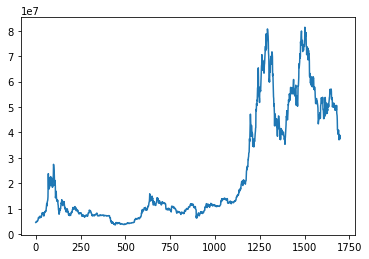

In [8]:
data['open'].plot()

In [9]:
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

time_series = data['open']
diff1 = pd.Series(difference(time_series, 1))
diff1.shape

(1699,)

<AxesSubplot:>

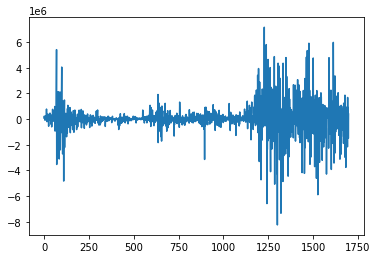

In [10]:
diff1.plot()

In [11]:
from statsmodels.tsa.stattools import adfuller 

result = adfuller(time_series, autolag='AIC')
result

(-1.375655164610864,
 0.5938901032077417,
 5,
 1694,
 {'1%': -3.4342161374093405,
  '5%': -2.863247682032273,
  '10%': -2.5676791252688496},
 51360.912532843955)

In [25]:
result[1]

0.5938901032077417

In [26]:
result2 = adfuller(diff1, autolag='AIC')
result2

(-15.816147905498013,
 1.032975894720297e-28,
 4,
 1694,
 {'1%': -3.4342161374093405,
  '5%': -2.863247682032273,
  '10%': -2.5676791252688496},
 51330.78729324579)

In [17]:
# scaler

class MeanScaler:
    
    def fit_transform(self, y):
        self.mean = np.mean(y)
        return y / self.mean
    
    def inverse_transform(self, y):
        return y * self.mean

    def transform(self, y):
        return y / self.mean

## Model

In [12]:
class Gaussian(nn.Module):

    def __init__(self, hidden_size, output_size):
        '''
        Gaussian Likelihood Supports Continuous Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(Gaussian, self).__init__()
        self.mu_layer = nn.Linear(hidden_size, output_size)
        self.sigma_layer = nn.Linear(hidden_size, output_size)

        # initialize weights
        # nn.init.xavier_uniform_(self.mu_layer.weight)
        # nn.init.xavier_uniform_(self.sigma_layer.weight)
    
    def forward(self, h):
        _, hidden_size = h.size()
        sigma_t = torch.log(1 + torch.exp(self.sigma_layer(h))) + 1e-6
        sigma_t = sigma_t.squeeze(0)
        mu_t = self.mu_layer(h).squeeze(0)
        return mu_t, sigma_t

def gaussian_sample(mu, sigma):
    '''
    Gaussian Sample
    Args:
    ytrue (array like)
    mu (array like)
    sigma (array like): standard deviation
    gaussian maximum likelihood using log 
        l_{G} (z|mu, sigma) = (2 * pi * sigma^2)^(-0.5) * exp(- (z - mu)^2 / (2 * sigma^2))
    '''
    # likelihood = (2 * np.pi * sigma ** 2) ** (-0.5) * \
    #         torch.exp((- (ytrue - mu) ** 2) / (2 * sigma ** 2))
    # return likelihood
    gaussian = torch.distributions.normal.Normal(mu, sigma)
    ypred = gaussian.sample()
    if ypred.dim() == 1:
        ypred = ypred.unsqueeze(0)
    return ypred

def gaussian_likelihood_loss(z, mu, sigma):
    '''
    Gaussian Liklihood Loss
    Args:
    z (tensor): true observations, shape (num_ts, num_periods)
    mu (tensor): mean, shape (num_ts, num_periods)
    sigma (tensor): standard deviation, shape (num_ts, num_periods)
    likelihood: 
    (2 pi sigma^2)^(-1/2) exp(-(z - mu)^2 / (2 sigma^2))
    log likelihood:
    -1/2 * (log (2 pi) + 2 * log (sigma)) - (z - mu)^2 / (2 sigma^2)
    '''
    negative_likelihood = torch.log(sigma + 1) + (z - mu) ** 2 / (2 * sigma ** 2) + 6
    return negative_likelihood.mean()

In [13]:
class DeepAR(nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, num_layers, lr=1e-3, likelihood="g"):
        super(DeepAR, self).__init__()

        # network
        self.input_embed = nn.Linear(1, embedding_size)
        self.encoder = nn.LSTM(embedding_size+input_size, hidden_size, \
                num_layers, bias=True, batch_first=True)
        if likelihood == "g":
            self.likelihood_layer = Gaussian(hidden_size, 1)

        self.likelihood = likelihood

    def forward(self, X, y, Xf):
        num_ts, seq_len, _ = X.size() # 64, 168, 2
        _, output_horizon, num_features = Xf.size() # 64, 60, 2

        ynext = None
        ypred = []
        mus = []
        sigmas = []       
        h, c = None, None
        for s in range(seq_len + output_horizon):
            if s < seq_len:
                ynext = y[:, s].view(-1, 1) # (batch_size, 1) 
                yembed = self.input_embed(ynext).view(num_ts, -1) # (batch_size, embed_size)
                x = X[:, s, :].view(num_ts, -1) # (batch_size, num_feature)
            else:
                yembed = self.input_embed(ynext).view(num_ts, -1) # (batch_size, embed_size)
                x = Xf[:, s-seq_len, :].view(num_ts, -1) # (batch_size, num_feature)
            x = torch.cat([x, yembed], dim=1) # (batch_size, num_feature+embed_size)
            inp = x.unsqueeze(1) # (batch_size, 1, num_feature+embed_size)
            if h is None and c is None:
                out, (h, c) = self.encoder(inp) # h size (num_layers, num_ts, hidden_size)
            else:
                out, (h, c) = self.encoder(inp, (h, c))

            hs = h[-1, :, :] # (batch_size, hidden_size)
            hs = F.relu(hs)
            mu, sigma = self.likelihood_layer(hs)
            mus.append(mu.view(-1, 1))
            sigmas.append(sigma.view(-1, 1))
            if self.likelihood == 'g':
                ynext = gaussian_sample(mu, sigma)

            if s >= seq_len - 1 and s < output_horizon + seq_len - 1:
                ypred.append(ynext)
                
        ypred = torch.cat(ypred, dim=1).view(num_ts, -1)
        mu = torch.cat(mus, dim=1).view(num_ts, -1)
        sigma = torch.cat(sigmas, dim=1).view(num_ts, -1)
        return ypred, mu, sigma   
        

## Train

In [22]:
# metric

def MAPE(ytrue, ypred):
    ytrue = np.array(ytrue).ravel() + 1e-4
    ypred = np.array(ypred).ravel()
    return np.mean(np.abs((ytrue - ypred) \
        / ytrue))

def MAPEval(y_pred, y_true):
    y_true = np.array(y_true).ravel() + 1e-4
    y_pred = np.array(y_pred).ravel()    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
def train(data):
    # num_ts, num_periods, num_features = X.shape
    model = DeepAR(2, embedding_size, 
        hidden_size, n_layers)

    optimizer = Adam(model.parameters(), lr=lr)
    random.seed(42)
    
    losses = []
    cnt = 0

    # train / test split
    train_periods = int(data.shape[0] * 0.8)

    data_tr = data.iloc[:train_periods, :]
    data_te = data.iloc[train_periods:, :]

    data_tr = data_tr[['open','hour','day_of_week']]
    data_tr.reset_index(drop=True, inplace=True)

    data_te = data_te[['open','hour','day_of_week']]
    data_te.reset_index(drop=True, inplace=True)
    
    yscaler = MeanScaler()
    tmp = yscaler.fit_transform(data_tr['open'])
    data_tr['open'] = tmp

    custom_dataset = WindowDataset(data_tr, num_obs_to_train, seq_len)
    train_dataloader = DataLoader(custom_dataset, batch_size) 

    #-- train
    progress = ProgressBar()

    for epoch in progress(range(num_epochs)):
        for X, Y, Xf, Yf in train_dataloader:
            ypred, mu, sigma = model(X, Y, Xf)
            ytrain_tensor = torch.cat([Y, Yf], dim=1)
            z = ytrain_tensor.squeeze(2)
            loss = gaussian_likelihood_loss(z, mu, sigma)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cnt += 1

    #-- test 
    mape_list = []

    tmp = yscaler.transform(data_te['open'])
    data_te['open'] = tmp

    custom_dataset = WindowDataset(data_te, num_obs_to_train, seq_len)
    test_dataloader = DataLoader(custom_dataset, 1)   

    X_te, Y_te, Xf_te, Yf_te = next(iter(test_dataloader))  

    n_samples = 100
    result = []
    for _ in tqdm(range(n_samples)):
        y_pred, _, _ = model(X_te, Y_te, Xf_te)
        y_pred = y_pred.data.numpy()
        y_pred = yscaler.inverse_transform(y_pred)

        result.append(y_pred.reshape((-1,1)))

    result = np.concatenate(result, axis=1)
    p50 = np.quantile(result, 0.5, axis=1)
    p60 = np.quantile(result, 0.6, axis=1)
    p40 = np.quantile(result, 0.4, axis=1)   

    y_true = yscaler.inverse_transform(Yf_te.data.numpy())
    mape = MAPEval(p50, y_true)
    print("P50 MAPE: {}".format(mape))
    mape_list.append(mape)    

    Y_total = torch.concat([Y_te, Yf_te], dim=1)
    Y_total = yscaler.inverse_transform(Y_total.data.numpy())
    plt.figure(1, figsize=(20, 5))
    plt.plot([k + seq_len + num_obs_to_train - seq_len \
        for k in range(seq_len)], p50, "r-")
    plt.fill_between(x=[k + seq_len + num_obs_to_train - seq_len for k in range(seq_len)], \
        y1=p40, y2=p60, alpha=0.5)
    plt.title('Prediction uncertainty')
    yplot = Y_total[-1, -seq_len-num_obs_to_train:]
    plt.plot(range(len(yplot)), yplot, "k-")
    plt.legend(["P50 forecast", "P40-P60 quantile", "true"], loc="upper left")
    ymin, ymax = plt.ylim()
    plt.vlines(seq_len + num_obs_to_train - seq_len, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
    plt.ylim(ymin, ymax)
    plt.xlabel("Periods")
    plt.ylabel("Y")
    # plt.show()
    plt.savefig(f'../img/deepar_pred.png')

    return losses, mape_list, p50, y_true


100% |########################################################################|
100%|██████████| 100/100 [00:03<00:00, 25.84it/s]


P50 MAPE: 5.267868632472021


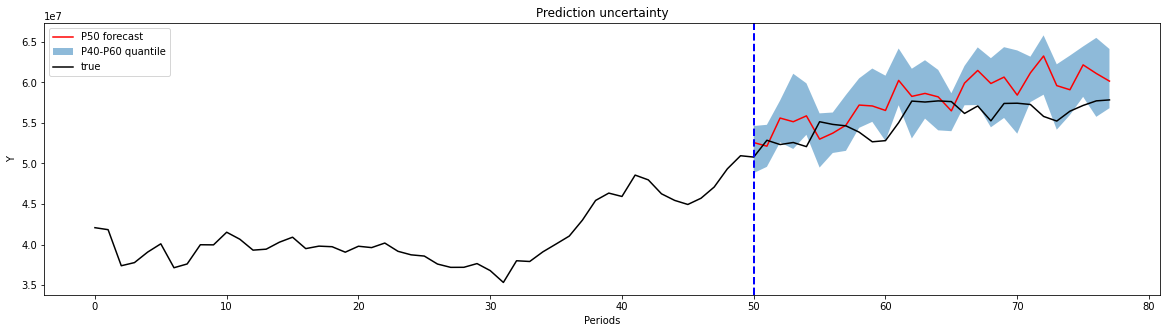

In [44]:
losses, mape_list, p50, Yf_true = train(data)

In [45]:
p50

array([52578310., 52131636., 55600258., 55148896., 55869420., 52998734.,
       53739212., 54724732., 57200748., 57090110., 56536740., 60242324.,
       58270038., 58636460., 58209528., 56486266., 59906748., 61466658.,
       59857774., 60647760., 58425818., 61172020., 63246988., 59596420.,
       59087440., 62154566., 61094868., 60150858.])

In [46]:
Yf_true.ravel()

array([50790000., 52862000., 52335000., 52585000., 52078000., 55145000.,
       54817000., 54638000., 53863000., 52674000., 52815000., 55030000.,
       57690000., 57576000., 57714000., 57627000., 56168000., 57088000.,
       55255000., 57400000., 57428000., 57272000., 55800000., 55228000.,
       56445000., 57155000., 57717000., 57836000.], dtype=float32)

In [47]:
mape_list

[5.267868632472021]

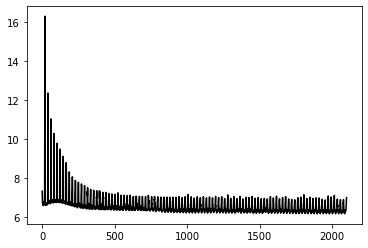

In [48]:
plt.plot(range(len(losses)), losses, "k-")